In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
FoVPerspectiveCameras, look_at_view_transform,
look_at_rotation, RasterizationSettings,
MeshRenderer, MeshRasterizer, BlendParams,
SoftSilhouetteShader, HardPhongShader,
PointLights, SoftPhongShader
)

from pathlib import Path
from tqdm import tqdm
import imageio, PIL

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
output_dir = Path('./result_cow')
data_dir = Path('./data/cow_mesh')

In [4]:
obj_filename = data_dir / 'cow.obj'
cow_mesh = load_objs_as_meshes([obj_filename], device=device)

In [5]:
cameras = FoVPerspectiveCameras(device=device)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0), ))

### Силуэтный

In [6]:
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

### Текстурный

In [7]:
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
        image_size=256,
        blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
        faces_per_pixel=50,
    )
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

### Для визуализации

In [8]:
raster_settings = RasterizationSettings(
        image_size=256,
        blur_radius=0.0,
        faces_per_pixel=1,
    )
phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
            shader=HardPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )

### Камера

In [9]:
distance = 3
elevation = 50.0
azimuth = 0.0
R, T = look_at_view_transform(distance,
                              elevation,
                              azimuth,
                              device=device)

In [10]:
silhouette = renderer_silhouette(meshes_world=cow_mesh,
                                 R=R, T=T)
image_ref = phong_renderer(meshes_world=cow_mesh,
                           R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_silhouette.png'))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_rgb.png'))
plt.close()

### Модель

In [11]:
class Model(nn.Module):
    def __init__(self, meshes, renderer_silhouette, renderer_textured, image_ref, weight_silhouette, weight_texture):
        super().__init__()
        
        self.meshes = meshes
        self.device = meshes.device
        self.renderer_silhouette = renderer_silhouette
        self.renderer_textured = renderer_textured
        self.weight_silhouette = weight_silhouette
        self.weight_texture = weight_texture
        
        image_ref_silhouette = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref_silhouette', image_ref_silhouette)
        
        image_ref_textured = torch.from_numpy((image_ref[..., :3]).astype(np.float32))
        self.register_buffer('image_ref_textured', image_ref_textured)
        
        self.camera_position = nn.Parameter(torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device))
        
    def forward(self):
        R = look_at_rotation( self.camera_position[None, :], device=self.device) # (1, 3, 3)
        T = -torch.bmm(
            R.transpose(1, 2),
            self.camera_position[None, :, None])[:, :, 0] # (1, 3)
        
        image_silhouette = self.renderer_silhouette(meshes_world=self.meshes.clone(), R=R, T=T)
        image_textured = self.renderer_textured(meshes_world=self.meshes.clone(), R=R, T=T)
        
        loss_silhouette = torch.sum((image_silhouette[..., 3] - self.image_ref_silhouette) ** 2)
        loss_texture = torch.sum((image_textured[..., :3] - self.image_ref_textured) ** 2)
        loss = self.weight_silhouette * loss_silhouette + self.weight_texture * loss_texture
        return loss, image_silhouette, image_textured

In [12]:
model = Model(meshes=cow_mesh,
              renderer_silhouette=renderer_silhouette,
              renderer_textured=renderer_textured,
              image_ref=image_ref, weight_silhouette=1.0,
              weight_texture=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [13]:
epochs = 200
images = []
for i in tqdm(range(epochs)):        
    loss, image_silhouette, image_textured = model()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    plt.figure()
    plt.imshow(image_silhouette[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_silhouette_' + str(i) + '.png'))
    plt.close()
        
    plt.figure()
    plt.imshow(image_textured.detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir,
    'soft_texture_' + str(i) + '.png'))
    plt.close()
    
    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0] # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)

    plt.figure()
    plt.imshow(image[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_silhouette_' + str(i) + '.png'))
    plt.close()
    
    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)
    images.append(image)

    plt.figure()
    plt.imshow(image[..., :3])
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_texture_' + str(i) + '.png'))
    plt.close()
    
    if loss.item() < 800:
        break


imageio.mimsave(output_dir / 'cow.gif', images)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:48<00:00,  1.84it/s]


### Попробуем исходный код

i =  0
i =  10
i =  20
i =  30
i =  40
i =  50
i =  60
i =  70
i =  80
i =  90
i =  100
i =  110
i =  120
i =  130
i =  140
i =  150
i =  160
i =  170
i =  180
i =  190
Finished


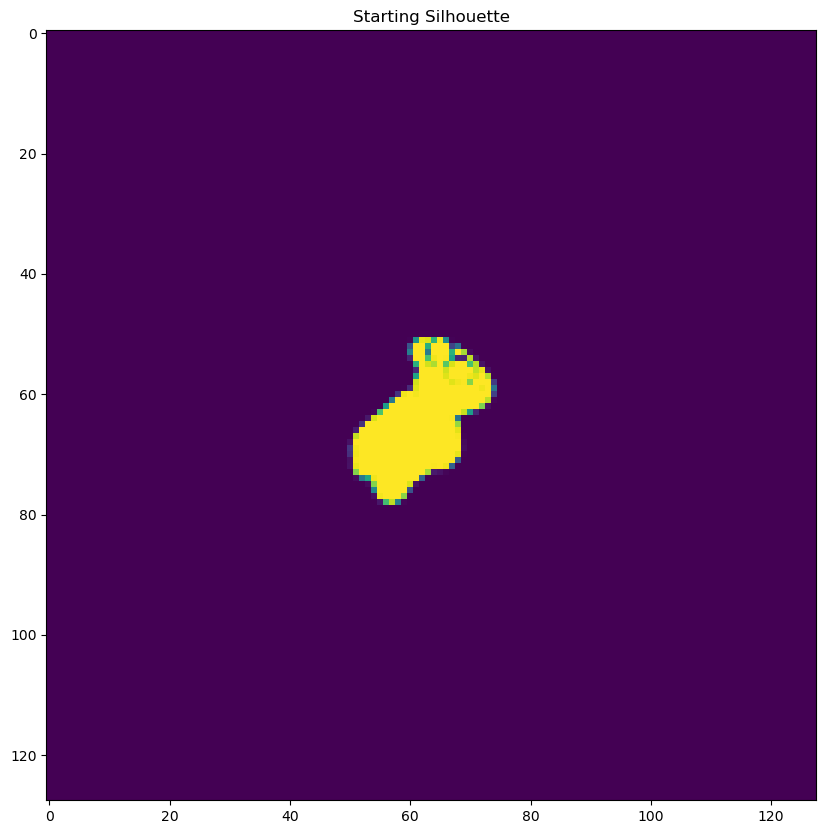

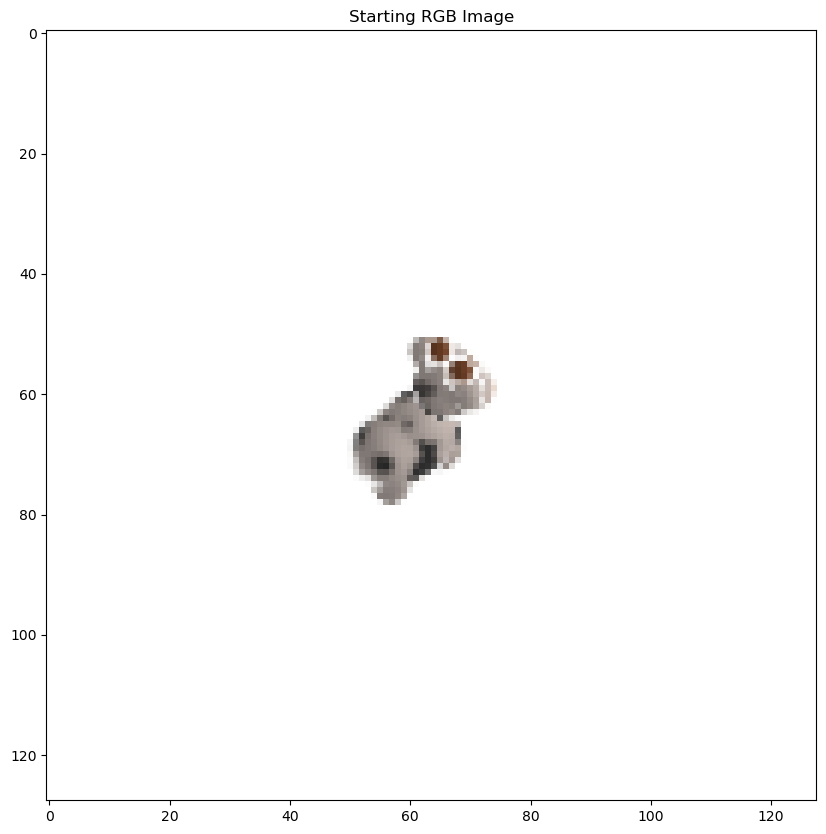

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

from pytorch3d.io import load_objs_as_meshes

from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights,
    SoftPhongShader
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

output_dir = './result_cow'

obj_filename = "./data/cow_mesh/cow.obj"
cow_mesh = load_objs_as_meshes([obj_filename], device=device)

cameras = FoVPerspectiveCameras(device=device)
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=100,
)

renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device,
        cameras=cameras,
        lights=lights)
)

raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

distance = 3
elevation = 50.0
azimuth = 0.0
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

silhouette = renderer_silhouette(meshes_world=cow_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=cow_mesh, R=R, T=T)
silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_silhouette.png'))
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image_ref.squeeze())
plt.grid(False)
plt.savefig(os.path.join(output_dir, 'target_rgb.png'))
plt.close()

class Model(nn.Module):
    def __init__(self, meshes, renderer_silhouette, renderer_textured, image_ref, weight_silhouette, weight_texture):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer_silhouette = renderer_silhouette
        self.renderer_textured = renderer_textured

        self.weight_silhouette = weight_silhouette
        self.weight_texture = weight_texture

        image_ref_silhouette = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref_silhouette', image_ref_silhouette)

        image_ref_textured = torch.from_numpy((image_ref[..., :3]).astype(np.float32))
        self.register_buffer('image_ref_textured', image_ref_textured)

        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]  # (1, 3)

        image_silhouette = self.renderer_silhouette(meshes_world=self.meshes.clone(), R=R, T=T)
        image_textured = self.renderer_textured(meshes_world=self.meshes.clone(), R=R, T=T)

        loss_silhouette = torch.sum((image_silhouette[..., 3] - self.image_ref_silhouette) ** 2)
        loss_texture = torch.sum((image_textured[..., :3] - self.image_ref_textured) ** 2)

        loss = self.weight_silhouette * loss_silhouette + self.weight_texture * loss_texture
        return loss, image_silhouette, image_textured

model = Model(meshes=cow_mesh, renderer_silhouette=renderer_silhouette, renderer_textured = renderer_textured,
              image_ref=image_ref, weight_silhouette=1.0, weight_texture=0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

_, image_silhouette_init, image_rgb_init = model()
plt.figure(figsize=(10, 10))
plt.imshow(image_silhouette_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting Silhouette")
plt.savefig(os.path.join(output_dir, 'starting_silhouette.png'))

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb_init.cpu().detach().numpy().squeeze())
plt.grid(False)
plt.title("Starting RGB Image");
plt.savefig(os.path.join(output_dir, 'starting_rgb.png'))

for i in range(0, 200):
    if i%10 == 0:
        print('i = ', i)

    optimizer.zero_grad()
    loss, image_silhouette, image_textured = model()
    loss.backward()
    optimizer.step()

    plt.figure()
    plt.imshow(image_silhouette[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_silhouette_' + str(i) + '.png'))
    plt.close()

    plt.figure()
    plt.imshow(image_textured.detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'soft_texture_' + str(i) + '.png'))
    plt.close()

    R = look_at_rotation(model.camera_position[None, :], device=model.device)
    T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]  # (1, 3)
    image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)

    plt.figure()
    plt.imshow(image[..., 3].detach().squeeze().cpu().numpy())
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_silhouette_' + str(i) + '.png'))
    plt.close()

    image = image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = img_as_ubyte(image)

    plt.figure()
    plt.imshow(image[..., :3])
    plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
    plt.axis("off")
    plt.savefig(os.path.join(output_dir, 'hard_texture_' + str(i) + '.png'))
    plt.close()

    if loss.item() < 800:
        break

print('Finished')